# Currency Exchange

# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [3]:
df = pd.read_csv('data/finance_datasets/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
# cut to only 2017
idx = pd.to_datetime(df['Unnamed: 0']) < np.datetime64('2018-01-01')
df = df[idx]

In [5]:
data = []
for c in cols:
    data.append(mogptk.Data(X=df['Day'].values,
                            Y=df[c].values,
                            name=c))
#for d in data:
#    d.transform(mogptk.TransformDetrend)

In [6]:
cols[5]

'AUD/USD'

In [6]:
# randomly sample from the data
# for channel in data:
    # channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure
last_day = df['Day'].iloc[-1]
# data[0].remove_range(last_day, None)
# data[1].remove_range(90, 120)
  # data[2].remove_range(480, 520)
# data[2].remove_range(last_day, None)
# data[3].remove_range(200, 250)
# data[4].remove_range(None, 30)
  # data[5].remove_range(None, 30)
# data[5].remove_range(last_day, None)
# data[7].remove_range(None, 30)

cols2keep = [0, 2, 5]

for i in range(1, len(cols)):
    if i not in cols2keep:
        data[i].remove_range(last_day - 40, None)
# add pred values
# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

In [7]:
total = 0
for d in data:
    total += (~d.mask).sum()
total

196

## Create and fit model

Remove data to simulate sensor failure

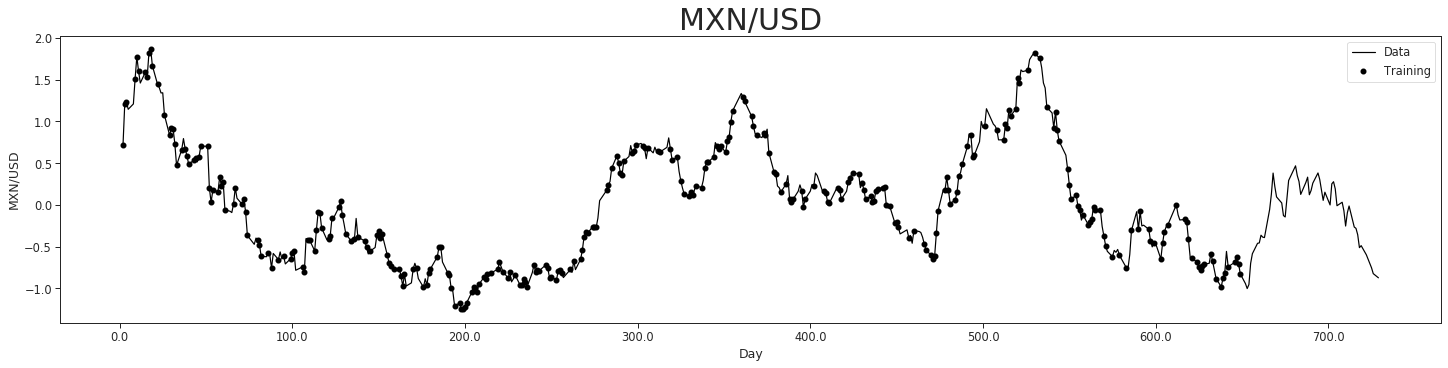

In [6]:
i = 9
data[i].plot()

# ARMA

In [8]:
# cols2keep = [0, 2, 5]

cols2use = [1, 3, 4, 6, 7, 8, 9]

/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


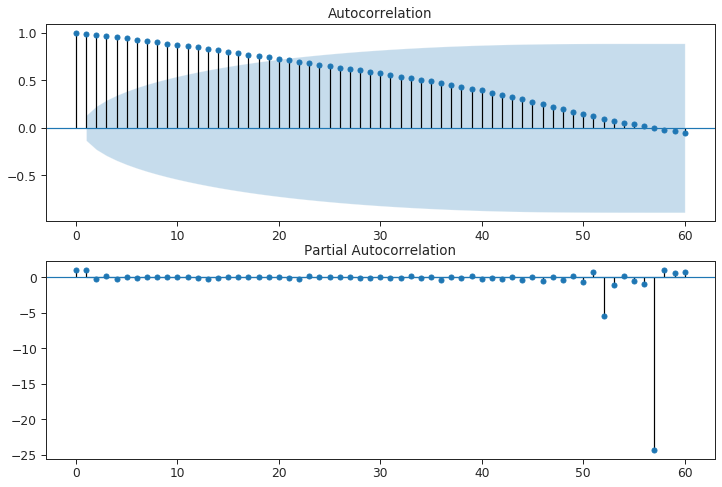

In [9]:
import statsmodels.api as sm

i = 1
y_train = data[i].Y[data[i].mask]
y_all = data[i].Y

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train, lags=60, ax=ax2)

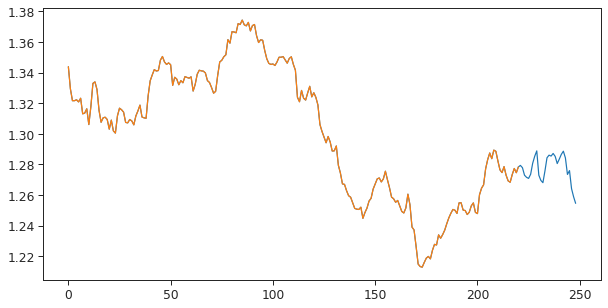

In [10]:
plt.plot(y_all)
plt.plot(y_train)

In [11]:
%%time
order_range = 5

n_trials = 5
arma_nmae = np.zeros((n_trials, len(cols2use)))
arma_nrmse = np.zeros((n_trials, len(cols2use)))

for n in range(n_trials):
    for i, c in enumerate(cols2use):
        best_aic = np.inf
        best_model = None
        best_order = None
        
        y_train = data[c].Y[data[c].mask]
        y_test = data[c].Y
        
        for p in range(order_range):
            for q in range(order_range):
                try:
                    model = sm.tsa.ARMA(y_train, (p, q)).fit();
                    model_aic = model.aic;
                except:
                    print('Failed with order', p, q)
                    continue
                if model_aic < best_aic:
                    best_aic = model_aic
                    best_model = model
                    best_order = (p, q)
        print('Best model for channel {} with order {} and aic {}'.format(c, best_order, best_aic))
        y_pred = best_model.predict(1, len(y_test))
        
        error = y_test[len(y_train):] - y_pred[len(y_train):]
        
        arma_nmae[n, i] = np.abs(error).mean() / y_test[len(y_train):].mean()
        arma_nrmse[n, i] = (error**2).mean() / y_test[len(y_train):].mean()

Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Failed with order 2 2
Failed with order 2 3
Failed with order 2 4
Failed with order 3 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Failed with order 4 2
Failed with order 4 3
Failed with order 4 4
Best model for channel 1 with order (1, 1) and aic -1693.329706459036
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInv

Best model for channel 3 with order (1, 0) and aic -1787.794495615441
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Best model for channel 4 with order (1, 0) and aic -1787.9695148844253
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 6 with order (3, 2) and aic -2029.2875050500197
Failed with order 0 4
Best model for channel 7 with order (4, 3) and aic -1524.8170425662179
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Like

Best model for channel 8 with order (1, 0) and aic 1427.6929703894402
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 9 with order (3, 2) and aic -286.85839074529633
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Failed with order 2 2
Failed with order 2 3
Failed with order 2 4
Failed with order 3 4
Failed with order 4 2
Failed with order 4 3
Failed with order 4 4
Best model for channel 1 with order (1, 1) and aic -1693.329706459036
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInv

Best model for channel 3 with order (1, 0) and aic -1787.794495615441
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Best model for channel 4 with order (1, 0) and aic -1787.9695148844253
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 6 with order (3, 2) and aic -2029.2875050500197
Failed with order 0 4
Best model for channel 7 with order (4, 3) and aic -1524.8170425662179
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Like

Best model for channel 8 with order (1, 0) and aic 1427.6929703894402
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 9 with order (3, 2) and aic -286.85839074529633
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Failed with order 2 2
Failed with order 2 3
Failed with order 2 4
Failed with order 3 4
Failed with order 4 2
Failed with order 4 3
Failed with order 4 4
Best model for channel 1 with order (1, 1) and aic -1693.329706459036
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInv

Best model for channel 3 with order (1, 0) and aic -1787.794495615441
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Best model for channel 4 with order (1, 0) and aic -1787.9695148844253
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 6 with order (3, 2) and aic -2029.2875050500197
Failed with order 0 4
Best model for channel 7 with order (4, 3) and aic -1524.8170425662179
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Like

Best model for channel 8 with order (1, 0) and aic 1427.6929703894402
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 9 with order (3, 2) and aic -286.85839074529633
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Failed with order 2 2
Failed with order 2 3
Failed with order 2 4
Failed with order 3 4
Failed with order 4 2
Failed with order 4 3
Failed with order 4 4
Best model for channel 1 with order (1, 1) and aic -1693.329706459036
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInv

Best model for channel 3 with order (1, 0) and aic -1787.794495615441
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Best model for channel 4 with order (1, 0) and aic -1787.9695148844253
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 6 with order (3, 2) and aic -2029.2875050500197
Failed with order 0 4
Best model for channel 7 with order (4, 3) and aic -1524.8170425662179
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Like

Best model for channel 8 with order (1, 0) and aic 1427.6929703894402
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 9 with order (3, 2) and aic -286.85839074529633
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Failed with order 2 2
Failed with order 2 3
Failed with order 2 4
Failed with order 3 4
Failed with order 4 2
Failed with order 4 3
Failed with order 4 4
Best model for channel 1 with order (1, 1) and aic -1693.329706459036
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInv

Best model for channel 3 with order (1, 0) and aic -1787.794495615441
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4
Best model for channel 4 with order (1, 0) and aic -1787.9695148844253
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 6 with order (3, 2) and aic -2029.2875050500197
Failed with order 0 4
Best model for channel 7 with order (4, 3) and aic -1524.8170425662179
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Like

Best model for channel 8 with order (1, 0) and aic 1427.6929703894402
Failed with order 0 2
Failed with order 0 3
Failed with order 0 4


/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/alejandro/anaconda3/envs/TFGPU/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best model for channel 9 with order (3, 2) and aic -286.85839074529633
CPU times: user 15min 15s, sys: 9.05 s, total: 15min 24s
Wall time: 9min


In [14]:

arma_nmae.mean(1).mean() * 1e3, arma_nmae.mean(1).std()

(10.631199264542955, 0.0)

In [15]:

arma_nrmse.mean(1).mean() * 1e3, arma_nrmse.mean(1).std()

(74.93147810098782, 0.0)

# GONU

In [ ]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',
                     format={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      format={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',
                        format={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',
                     format={'Date': mogptk.FormatDate})

f_paths = [
    'data/gonu/brent-daily.csv',
    'data/gonu/lmba-gold-usd-am-daily.csv',
    'data/gonu/nasdaq.csv',
    'data/gonu/TWEXB.csv'
          ]
cols = ['Oil', 'Gold', 'NASDAQ', 'USD']

data = [oil, gold, nasdaq, usd]


np.random.seed(1)
for i, channel in enumerate(data):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7d')
    
    # channel.transform(mogptk.TransformLog)
    # channel.transform(mogptk.TransformDetrend)
    
    if i == 0:
        channel.remove_range('2018-10-05', None)
        # channel.remove_randomly(pct=0.3)
    if i == 1:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 2:
        # channel.remove_range('2018-10-01', None)
        channel.remove_randomly(pct=0.6)
        # channel.remove_range('2018-10-01', None)
        # channel.remove_range('2016-01-01', '2016-03-01')
        
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
    # channel.plot()
    
# for i, channel in enumerate(data):
    # channel.plot_spectrum(per='day')    
    # print('BNSE:', channel.get_bnse_estimation())
    # print('LombScargle:', channel.get_ls_estimation())
    
# oil.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# gold.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# nasdaq.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# usd.set_pred_range('2015-07-01', '2018-07-01', n=1000)

x_test = [channel.X[~channel.mask] for channel in data]
y_test = [mogptk.data._detransform(c.transformations, c.X, c.Y)[~c.mask] for c in data]

In [ ]:
import statsmodels.api as sm

In [ ]:
i = 0
y = data[i].Y[data[i].mask]
x = data[i].X[data[i].mask]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=60, ax=ax2)

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(data[i].X, data[i].Y)
plt.plot(x, y)

In [ ]:
%%time
order_range = 5

best_aic = np.inf
best_model = None
best_order = None

for p in range(order_range):
    for q in range(order_range):
        try:
            model = sm.tsa.ARMA(y, (p, q)).fit();
            model_aic = model.aic;
        except:
            print('Failed with order', p, q)
            continue
        if model_aic < best_aic:
            best_aic = model_aic
            best_model = model
            best_order = (p, q)
print('Best model with order {} and aic {}'.format(best_order, best_aic))


In [ ]:
y_pred = best_model.predict(1, len(data[i].Y), dynamic=False)

plt.figure(figsize=(10, 4))
plt.plot(data[i].Y, label='True')
plt.plot(y_pred, label='Pred')
plt.plot(y)
plt.legend()
# plt.xlim(190, 209)

In [ ]:
n_trials = 5
arma_mape = np.zeros((n_trials))
arma_nrmse = np.zeros((n_trials))

for n in range(n_trials):
    model = sm.tsa.ARMA(y, (1, 1)).fit();
    y_pred = model.predict(1, len(data[i].Y), dynamic=False)
    
    error = data[i].Y[len(y):] - y_pred[len(y):]
    
    arma_mape[n] = np.abs(error).mean() /  data[i].Y[len(y):].mean()
    arma_nrmse[n] = np.sqrt((error**2).mean()) / data[i].Y[len(y):].mean()

In [ ]:
data[i].Y[len(y):].mean()

In [ ]:
arma_mape.mean(), arma_mape.std()

In [ ]:
arma_nrmse.mean(), arma_nrmse.std()